In [1]:
import cf_xarray
import dask.distributed
import matplotlib.pyplot as plt
import numpy as np
import pyproj
import xarray as xr
import xesmf as xe

from dask.distributed import Client
#import s1_tools

%matplotlib inline


In [19]:
#%load_ext rich

## Read data for both datasets

In [2]:
%store -r da
pc_cube = da

In [3]:
pc_cube = pc_cube.compute()

In [4]:
timeseries_type = 'full'

asf_cube = xr.open_dataset(f'../../sentinel1/data/{timeseries_type}_timeseries/intermediate_cubes/s1_asf_clipped_cube.zarr',
                           engine='zarr',chunks='auto', decode_coords='all')
asf_cube = asf_cube.rename({'acq_date':'time'})
asf_cube = asf_cube.compute()

Check CRS metadata

In [5]:
pc_cube.rio.crs

CRS.from_epsg(32645)

In [6]:
asf_cube.rio.crs

for variable in asf_cube.data_vars:
    print(asf_cube[variable].rio.crs)

EPSG:32645
EPSG:32645


Subset PC timeseries to common elements with ASF time series:

In [7]:
asf_acq_dates = asf_cube.time.dt.date.data.tolist()
pc_subset = pc_cube.where(pc_cube.time.dt.date.isin(asf_acq_dates), drop=True)

Need to add CRS back in:

In [8]:
pc_subset = pc_subset.rio.write_crs(pc_cube.rio.crs)

Convert to `xr.DataArray`:

In [10]:
asf_cube = asf_cube.set_coords('ls')

In [11]:
asf_da = asf_cube.to_dataarray(dim='band')

Add CF attrs to `'band'` coordinate:

In [12]:
pc_subset['band'].attrs = {
    'long_name': 'Radar polarization',
    'cf_role': 'auxiliary_coordinate',
    'flag_meanings': 'vv vh'
}

In [13]:
asf_da['band'].attrs = {
    'long_name': 'Radar polarization',
    'cf_role': 'auxiliary_coordinate',
    'flag_meanings': 'vv vh'
}

Add CF attrs to backscatter

In [14]:
pc_subset.attrs = {
    'long_name': 'normalized radar backscatter coefficient',
    'units':1, #unitless
    'description': 'Normalized radar backscatter coefficient (gamma naught) for a given polarization band. Unitless until converted to dB or amplitude scale'
}

In [15]:
asf_da.attrs = {
    'long_name': 'normalized radar backscatter coefficient',
    'units':1, #unitless
    'description': 'Normalized radar backscatter coefficient (gamma naught) for a given polarization band. Unitless until converted to dB or amplitude scale'
}

Now, convert objects from `xr.DataArrays` to `xr.Datasets`:

In [16]:
pc_subset_ds = pc_subset.to_dataset(dim='band').drop_dims('band')


In [17]:
asf_ds = asf_da.to_dataset(dim='band')

### 1. First approach, use xesmf to regrid projected datasets by making datasets CF compliant

Make attrs necessary for CF compliance

In [18]:
def add_grid_mapping(ds:xr.Dataset):

    crs = pyproj.CRS(ds.rio.crs)

    #make grid mapping
    grid_mapping = crs.to_cf()
    #make coord sys
    cs = crs.cs_to_cf()

    #make grid mapping var
    grid_mapping_var = xr.DataArray(0, attrs=grid_mapping)
    #add to ds
    ds['grid_mapping'] = grid_mapping_var
    #set as coord
    ds = ds.set_coords('grid_mapping')
    return ds

In [19]:
asf_cube_cf = add_grid_mapping(asf_ds)
pc_subset_ds_cf = add_grid_mapping(pc_subset_ds)

Check attrs available for cf_xarray to interpret w/ `ds.cf.keys()`:

In [20]:
asf_cube_cf.cf.keys()

{'X',
 'Y',
 'projection_x_coordinate',
 'projection_y_coordinate',
 'transverse_mercator'}

In [21]:
pc_subset_ds_cf.cf.keys()

{'transverse_mercator'}

Because of how we read the two objects into memory initially (`xr.open_dataset()` for the ASF cube and `stackstac.stack()` for the PC cube), we need to manually add attributes to the x and y coordinate variables of the PC dataset.

In [22]:
pc_subset_ds_cf.x.attrs = asf_cube_cf.x.attrs
pc_subset_ds_cf.y.attrs = asf_cube_cf.y.attrs

Add grid mapping attr to x and y coords to point to the grid mapping variable (not sure this is necessary?)

In [23]:
pc_subset_ds_cf.x.attrs.update({'grid_mapping':'grid_mapping'})
pc_subset_ds_cf.y.attrs.update({'grid_mapping':'grid_mapping'})

asf_cube_cf.x.attrs.update({'grid_mapping':'grid_mapping'})
asf_cube_cf.y.attrs.update({'grid_mapping':'grid_mapping'})

Add bounds

In [25]:
pc_updated = pc_subset_ds_cf.cf.add_bounds(['x','y'])
asf_updated = asf_cube_cf.cf.add_bounds(['x','y'])

In [26]:
repr(asf_updated.cf)

"Coordinates:\n             CF Axes: * X: ['x']\n                      * Y: ['y']\n                        Z, T: n/a\n\n      CF Coordinates:   longitude, latitude, vertical, time: n/a\n\n       Cell Measures:   area, volume: n/a\n\n      Standard Names: * projection_x_coordinate: ['x']\n                      * projection_y_coordinate: ['y']\n\n              Bounds:   X: ['x_bounds']\n                        Y: ['y_bounds']\n                        projection_x_coordinate: ['x_bounds']\n                        projection_y_coordinate: ['y_bounds']\n                        x: ['x_bounds']\n                        y: ['y_bounds']\n\n       Grid Mappings:   transverse_mercator: ['grid_mapping', 'spatial_ref']\n\nData Variables:\n       Cell Measures:   area, volume: n/a\n\n      Standard Names:   n/a\n\n              Bounds:   n/a\n\n       Grid Mappings:   n/a"

In [27]:
repr(pc_updated.cf)

"Coordinates:\n             CF Axes: * X: ['x']\n                      * Y: ['y']\n                        Z, T: n/a\n\n      CF Coordinates:   longitude, latitude, vertical, time: n/a\n\n       Cell Measures:   area, volume: n/a\n\n      Standard Names: * projection_x_coordinate: ['x']\n                      * projection_y_coordinate: ['y']\n\n              Bounds:   X: ['x_bounds']\n                        Y: ['y_bounds']\n                        projection_x_coordinate: ['x_bounds']\n                        projection_y_coordinate: ['y_bounds']\n                        x: ['x_bounds']\n                        y: ['y_bounds']\n\n       Grid Mappings:   transverse_mercator: ['grid_mapping', 'spatial_ref']\n\nData Variables:\n       Cell Measures:   area, volume: n/a\n\n      Standard Names:   n/a\n\n              Bounds:   n/a\n\n       Grid Mappings:   n/a"

Try to make a `xe.Regridder` obj:

In [28]:
source_grid = {
    'x': pc_updated.x.values,
    'y': pc_updated.y.values,
}
target_grid = {
    'x': asf_updated.x.values,
    'y': asf_updated.y.values,
}
regridder = xe.Regridder(pc_updated, asf_updated, method='bilinear')

ValueError: dataset must include lon/lat or be CF-compliant

I'm missing something about how to make this fully cf complient
- is it something to do with SAR backscatter not being recognized as a CF variable? or probably something more simple about coords?

### 2nd approach, convert to geographic coords

Seems less desirable than keeping things in projected utm? but seems to work

In [29]:
asf_ll = asf_cube.rio.reproject('epsg:4326')
pc_ll = pc_subset_ds.rio.reproject('epsg:4326')

Make `xesmf.Regridder`:

In [30]:
pc_out_ll = xr.Dataset(
    {
        'lat': (['lat'], asf_ll.y.data),
        'lon': (['lon'], asf_ll.x.data)
    }
)
regridder = xe.Regridder(pc_ll, pc_out_ll, 'bilinear')

In [31]:
pc_out_ll = regridder(pc_ll)

In [32]:
pc_out_ll = pc_out_ll.rio.write_crs(pyproj.CRS.from_epsg(4326))

Project back to UTM

In [33]:
pc_out_prj = pc_out_ll.rename({'lat':'y',
                               'lon':'x'}).rio.reproject(pc_subset.rio.crs)

In [34]:
asf_prj = asf_ll.rio.reproject(asf_cube.rio.crs)

In [35]:
asf_ll

<xarray.Dataset> Size: 61MB
Dimensions:        (x: 317, y: 382, time: 63)
Coordinates:
  * x              (x) float64 3kB 88.21 88.21 88.21 88.21 ... 88.3 88.3 88.3
  * y              (y) float64 3kB 28.03 28.03 28.03 28.03 ... 27.93 27.93 27.93
    orbital_dir    (time) <U4 1kB 'asc' 'desc' 'asc' ... 'asc' 'desc' 'desc'
    product_id     (time) <U4 1kB '54B1' '971C' 'D35A' ... '5569' '33F5' 'CA1B'
    abs_orbit_num  (time) <U6 2kB '037745' '037884' ... '043134' '043309'
  * time           (time) datetime64[ns] 504B 2021-05-05T00:03:07 ... 2022-05...
    data_take_ID   (time) <U6 2kB '047463' '047898' ... '0526C4' '052C00'
    spatial_ref    int64 8B 0
Data variables:
    vh             (time, y, x) float32 31MB nan nan nan nan ... nan nan nan nan
    vv             (time, y, x) float32 31MB nan nan nan nan ... nan nan nan nan
Attributes: (12/13)
    area_or_clipped:                   e
    beam_mode:                         IW
    deadreckoning_or_demmatch:         d
    notfiltered_or_filtered:           n
    orbit_type:                        P
    output_type:                       g
    ...                                ...
    polarization_type:                 D
    primary_polarization:              V
    processing_software:               G
    sensor:                            S1A
    terrain_correction_pixel_spacing:  RTC30
    unmasked_or_watermasked:           u

### Visualize

In [36]:
def power_to_db(input_arr: np.array) -> np.array:
    """
    Convert power values to decibel (dB) scale.

    Parameters
    ----------
    input_arr : np.array
        Input array containing power values.

    Returns
    -------
    np.array
        Output array with values converted to decibel (dB) scale.
    """
    return 10 * np.log10(np.abs(input_arr))


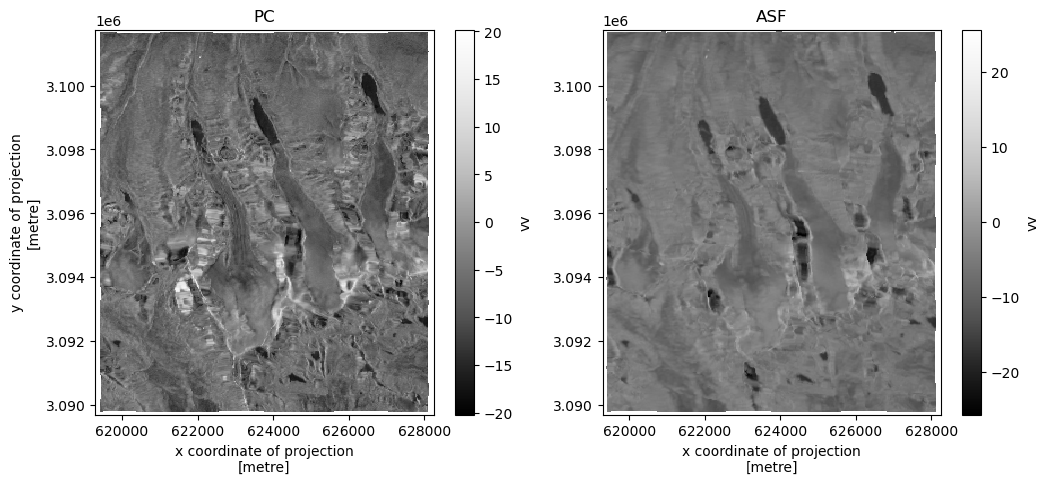

In [37]:
fig, ax = plt.subplots(ncols=2,figsize=(12,5))
power_to_db(pc_out_prj['vv'].mean(dim='time')).plot(cmap=plt.cm.Greys_r,
                                                             ax=ax[0])
power_to_db(asf_prj['vv'].mean(dim='time')).plot(cmap=plt.cm.Greys_r,
                                                           ax=ax[1])

ax[0].set_title('PC')
ax[1].set_title('ASF')
ax[1].set_ylabel(None);

In [41]:
np.testing.assert_array_equal(asf_prj.x.data, pc_out_prj.x.data)
np.testing.assert_array_equal(asf_prj.y.data, pc_out_prj.y.data)

### Compare to `xr.interp_like()`:

Create another downsampled PC dataset, this time using `xr.interp_like()`. 

In [43]:
pc_downsample = pc_subset.interp_like(asf_da)

Plot both downsampled objects:

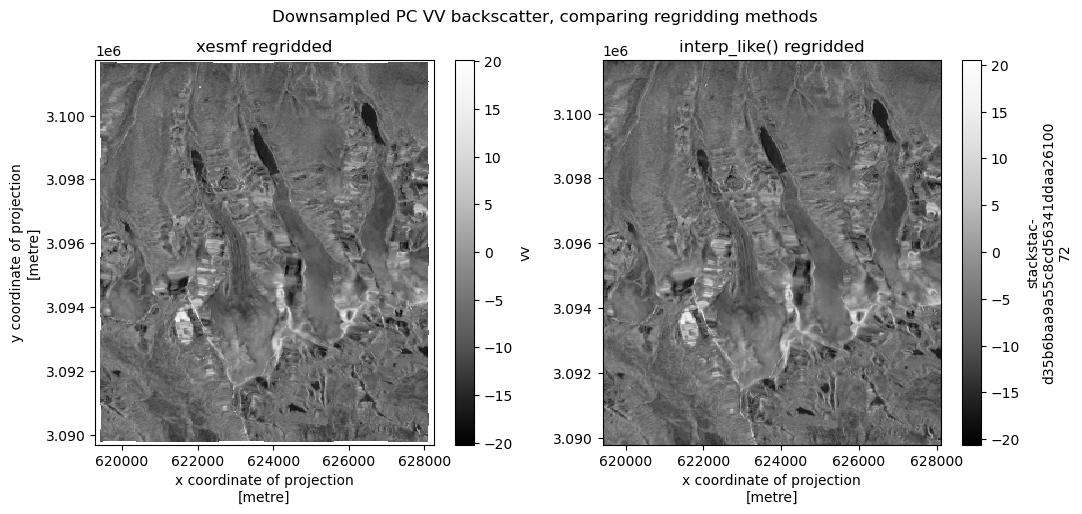

In [72]:
fig, ax = plt.subplots(ncols=2,figsize=(12,5))
power_to_db(pc_out_prj['vv'].mean(dim='time')).plot(cmap=plt.cm.Greys_r,
                                                             ax=ax[0])
power_to_db(pc_downsample.sel(band='vv').mean(dim='time')).plot(cmap=plt.cm.Greys_r,
                                                           ax=ax[1])

ax[0].set_title('xesmf regridded')
ax[1].set_title('interp_like() regridded')
ax[1].set_ylabel(None)
fig.suptitle('Downsampled PC VV backscatter, comparing regridding methods');

Compare the shapes of the two downsampled objects:

In [69]:
print('Shape of downsampled object made with xesmf regridding: \n', pc_out_prj.dims)

Shape of downsampled object made with xesmf regridding: 
 FrozenMappingWarningOnValuesAccess({'x': 299, 'y': 403, 'time': 63})


In [70]:
print('Shape of downsampled object made with xr.interp_like: \n',pc_downsample.to_dataset(dim='band').drop_dims('band').dims)

Shape of downsampled object made with xr.interp_like: 
 FrozenMappingWarningOnValuesAccess({'time': 63, 'y': 396, 'x': 290})


The xesmf regridded object a longer x-coordinate. In this case, because the geometries of the input objects were relatively similar, `xr.interp_like()` is an appropriate choice. If you are trying to regrid an object where there is greater dissimilarity between the target and source grids, options like XESMF may be a better choice. 